In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv("fake_job_postings.csv")

In [ ]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df = df.fillna('')


In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    return " ".join(text)

df['text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description']
df['text'] = df['text'].apply(clean_text)


In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text'])
y = df['fraudulent']


In [ ]:
svd = TruncatedSVD(n_components=300)
X_reduced = svd.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [ ]:
y_pred = model.predict(X_test)


Accuracy: 0.9753914988814317
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3395
           1       1.00      0.51      0.68       181

    accuracy                           0.98      3576
   macro avg       0.99      0.76      0.83      3576
weighted avg       0.98      0.98      0.97      3576



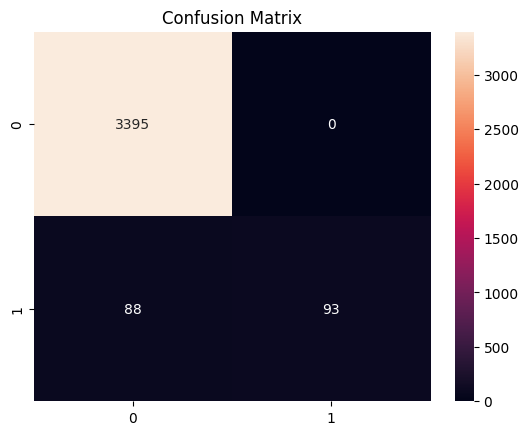

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


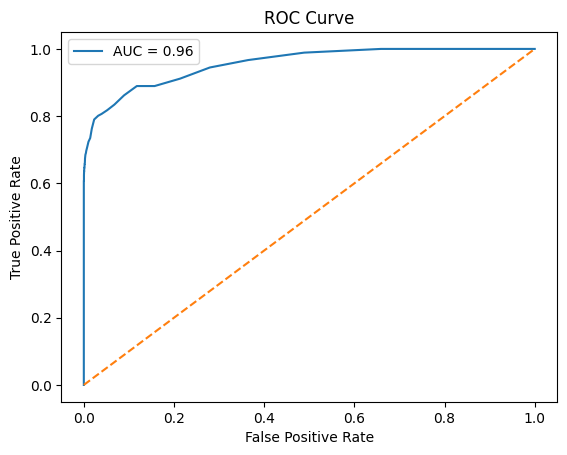

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label="AUC = %.2f" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['title', 'company_profile', 'description'], inplace=True)
df = df[df['fraudulent'].isin([0,1])]
df.reset_index(drop=True, inplace=True)


In [ ]:
df['text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description']

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = [3.2, 2.8, 4.5, 5.0]
y_pred = [3.0, 3.0, 4.4, 4.8]

print(mean_absolute_error(y_true, y_pred))
print(np.sqrt(mean_squared_error(y_true, y_pred)))
print(r2_score(y_true, y_pred))


0.17500000000000004
0.18027756377319956
0.9602142310635041


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_reduced)
print(silhouette_score(X_reduced, kmeans_labels))
print(davies_bouldin_score(X_reduced, kmeans_labels))

0.16792010359550347
0.7252640403002641


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(name, "Accuracy:", acc)


Random Forest Accuracy: 0.9748322147651006
Logistic Regression Accuracy: 0.9697986577181208
SVM Accuracy: 0.9779082774049217
